# My first molecular dynamics simulation

In [1]:
import time
import random

import sys

from io import StringIO
from IPython import get_ipython

from openmm.app import *
from openmm import *
from simtk.unit import *

import openmmtools as tools
import MDAnalysis as md
import nglview as ng
import pandas as pd
import numpy as np

# below prevents warnings from outdated Pandas append command clogging output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

t = int( time.time() * 1000.0 )
random.seed( ((t & 0xff000000) >> 24) +
             ((t & 0x00ff0000) >>  8) +
             ((t & 0x0000ff00) <<  8) +
             ((t & 0x000000ff) << 24)   )


In [2]:
class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        print("Water model undefined")  # optionally print some message to stdout, too
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


In [5]:
### 1. Choose a water model
# h2o = "NONE"
# h2o = "spce"
# h2o = "tip3p"
# h2o = "tip4pew"
# h2o = "tip5p"

if h2o =="NONE":
    raise IpyExit

### 2. Create initial coordinates and system
water = tools.testsystems.WaterBox(model=h2o,
                                   box_edge=2.1*nanometers,
                                   ewaldErrorTolerance=1e-04)

### 2a. Save initial coordinates to file
output = open('water.pdb', 'w')
PDBFile.writeFile(water.topology, water.positions, output)
output.flush()

In [6]:
### 3. Choose parameters of the experiment: temperature, pressure and length
temperature = 288*kelvin
pressure = 1*atmosphere
simulationTime = 10*picosecond

### 3a. Simulation timestep, total number of steps and thermostat/barostat parameters
timeStep = 0.002*picoseconds
totalSteps = simulationTime / timeStep
frictionCoeff = 0.1/picosecond
nupdt = 20

### 4. Choose an integrator
integrator = LangevinIntegrator( temperature, frictionCoeff, timeStep )
water.system.addForce(MonteCarloBarostat( pressure , temperature , nupdt ) )

### 5 Create a simulation object
simulation = Simulation(water.topology, water.system, integrator)
simulation.context.setPositions(water.positions)
simulation.context. setVelocitiesToTemperature(temperature, random.randrange(99999))

### 6. Set output for trajectory and thermodynamics data
simulation.reporters.append(DCDReporter('traj.dcd', 10))

### 7. Set output for thermodynamics data
simulation.reporters.append(StateDataReporter( "thermo.csv"
                                             , 10
                                             , step            = True
                                             , time            = True
                                             , potentialEnergy = True
                                             , temperature     = True
                                             , density         = True
                                             , volume          = True
                                             , separator       = ","
                                             ))

### 7a. Set screen output to monitor the simulation progress
simulation.reporters.append(StateDataReporter( sys.stdout
                                             , int(totalSteps/20)
                                             , step            = True
                                             , progress        = True
                                             , remainingTime   = True
                                             , elapsedTime     = True
                                             , separator       = " "
                                             , totalSteps      = totalSteps
                                             ))


In [7]:
### 8. Run MD
simulation.step(totalSteps)

#"Progress (%)" "Step" "Elapsed Time (s)" "Time Remaining"
5.0% 250 2.9802322387695312e-05 --
10.0% 500 0.9248077869415283 0:16
15.0% 750 1.8320038318634033 0:15
20.0% 1000 2.725062847137451 0:14
25.0% 1250 3.585536003112793 0:13
30.0% 1500 4.437191963195801 0:12
35.0% 1750 5.252994775772095 0:11
40.0% 2000 6.087436676025391 0:10
45.0% 2250 6.934940814971924 0:09
50.0% 2500 7.833104848861694 0:08
55.0% 2750 8.645012855529785 0:07
60.0% 3000 9.472530841827393 0:06
65.0% 3250 10.268924951553345 0:05
70.0% 3500 11.07167673110962 0:05
75.0% 3750 11.888775825500488 0:04
80.0% 4000 12.674637794494629 0:03
85.0% 4250 13.461643695831299 0:02
90.0% 4500 14.255128860473633 0:01
95.0% 4750 15.076814651489258 0:00
100.0% 5000 15.866933822631836 0:00


In [8]:
### 9. Visualization
sys = md.Universe("water.pdb", 'traj.dcd')
view = ng.show_mdanalysis(sys, gui=True)
view.center()
view.representations = [
    {"type": "ball+stick", "params": {"sele": "all"}}
]
view

/Users/paolo/opt/miniconda3/envs/work/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element EP found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/paolo/opt/miniconda3/envs/work/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: EP
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


NGLWidget(max_frame=499)

In [10]:
### 10. Load the thermodynamic data in a dataframe
data = pd.read_csv("thermo.csv")
# print(data.head())
print(data.tail())

     #"Step"  Time (ps)  Potential Energy (kJ/mole)  Temperature (K)  \
495     4960       9.92                -6110.804236       618.713532   
496     4970       9.94                -6022.051693       605.678315   
497     4980       9.96                -6149.933455       621.774572   
498     4990       9.98                -6108.264316       615.065500   
499     5000      10.00                -6096.783683       612.272757   

     Box Volume (nm^3)  Density (g/mL)  
495          14.559868        0.597897  
496          14.559868        0.597897  
497          14.555736        0.598067  
498          14.555736        0.598067  
499          14.618682        0.595492  


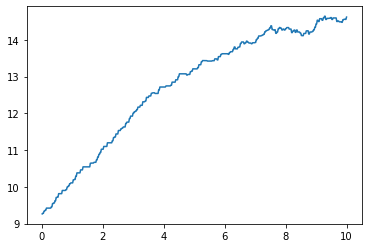

In [11]:
x = data["Time (ps)"]
y = data["Box Volume (nm^3)"]
plt.plot(x,y)
plt.show()